In [1]:
#Import the libraries required.
import requests
import json
import pandas as pd
from datetime import datetime 
import quandl
import numpy as np
import matplotlib.pyplot as plt

### Extract the time series from Quandl API.

In [2]:
#Access to the quandl python library using my API key
#Extract the dataset of Nvidia using WIKI resources.
quandl.ApiConfig.api_key = "AzKsaQu6EwrmivkQsCmu"
dataset_code = "WIKI/NVDA"

#Create a new dataframe that contains the daily price of Nvidia from 1999 to 2018.
###Notice that I set the end date to "2018-03-27" because WIKI stopped its service afterwards.
###The free version of NASDAQ API key doesn't give access to many datasets, so we will use old data here.
nvidia_table = quandl.get(dataset_code, end_date = "2018-03-27")
nvidia_price = nvidia_table[["Adj. Close"]].copy()
nvidia_price.rename(columns = {"Adj. Close": "Nvidia Price"}, inplace = True)

In [3]:
nvidia_price

,Nvidia Price
Date,
1999-01-22,1.522529
1999-01-25,1.681818
1999-01-26,1.551139
1999-01-27,1.546499
1999-01-28,1.541860
...,...
2018-03-21,248.560000
2018-03-22,241.850000
2018-03-23,232.970000


### Extract the time series from CryptoCompare API.

In [4]:
#Set the cryptocurrency to BTC.
#Extract the crypto dataset up to the same date as the Nvidia dataset.
###2000 rows is the maximum we can get using the free API key.
row = "2000"
end_date = "2018-03-27"
end_date_unix = str(datetime.strptime(end_date, "%Y-%m-%d").timestamp())
crypto_type = "BTC"
crypto_price = pd.DataFrame()
cryptocompare_api_key = "c15040c8c89e7906b2010e4d3b96b2b951f91e1ee716cf9bfe3e1f261c7a05e0"

#Extract the data from CryptoCompare API.
#Normalise the data and change the time from unix to data format.
cryptocompare_url = "https://min-api.cryptocompare.com/data/histoday?fsym="+crypto_type+"&tsym=USD&limit="+row+"&api_key="+cryptocompare_api_key+"&toTs="+end_date_unix
crypto_data = requests.get(cryptocompare_url).json()
crypto_table = pd.json_normalize(crypto_data, "Data")
crypto_table["time"] = pd.to_datetime(crypto_table["time"], unit = "s")
crypto_price = crypto_table[["time", "high"]].copy()    
crypto_price.rename(columns = {"time": "Date", "high": "BTC Price"}, inplace = True)
crypto_price.set_index("Date", inplace = True)

In [5]:
crypto_price

,BTC Price
Date,
2012-10-03,12.99
2012-10-04,13.09
2012-10-05,12.97
2012-10-06,12.86
2012-10-07,12.62
...,...
2018-03-22,9107.00
2018-03-23,8935.88
2018-03-24,9036.23


### Merge two datasets with matching dates.

In [6]:
joint_data = nvidia_price.join(crypto_price, how = "inner")

#Our sample data will be the last 200 rows from the joint dataset.
###These data have greater significance for study purposes due to the closer timeline to present time.
###We use 200 rows to ensure that there is a sufficient size of data for time series analysis.
###Good Trade-off between bias and variance, preventing the occurance of overfitting.
sample_data = joint_data.tail(200)

In [7]:
sample_data

,Nvidia Price,BTC Price
Date,,
2017-06-08,159.814322,2808.41
2017-06-09,149.471233,2852.07
2017-06-12,149.840914,2985.06
2017-06-13,151.269683,2784.77
2017-06-14,151.589408,2803.72
...,...,...
2018-03-20,249.580000,9056.23
2018-03-21,248.560000,9184.51
2018-03-22,241.850000,9107.00


In [8]:
#The prices for Nvidia and BTC are stored as variable x_t and y_t respectively.
x_t = sample_data["Nvidia Price"].round(2).tolist()
y_t = sample_data["BTC Price"].tolist()

### Method 1: standard OLS formulae


In [9]:
#Find the estimates, alpha and beta, using the OLS formula. 
#Find the predicted value of y_t.
#Find the loss function.
ols_beta = ((np.multiply(y_t, x_t)).mean() - np.mean(x_t) * np.mean(y_t)) / ((np.multiply(x_t, x_t)).mean() - np.mean(x_t) * np.mean(x_t))
ols_alpha = np.mean(y_t) - ols_beta * np.mean(x_t)
ols_y_hat = ols_alpha + np.multiply(ols_beta, x_t) 
ols_L = np.sum(np.multiply(y_t - ols_y_hat, y_t - ols_y_hat)) 

### Method 2: Gradient Descent (GD) Algorithm

Firstly, we need to normalise $x_{t}$ and $y_{t}$ to prevent the overflow issue. This happens when the gradient descent model becomes unstable when the variables have excessively large gradients. 

The normalisation formula is shown as below:

$$
\hat{x_{t}} = \frac {(x_{t} - \overline{x})} {\sigma_{x}}
$$

- $\hat{x_{t}}$ is the normalised $x_{t}$
- $\overline{x}$ is the mean of $x_{t}$
- $\sigma_{x}$ is the standard deviation of $x_{t}$

$$
\hat{y_{t}} = \frac {(y_{t} - \overline{y})} {\sigma_{y}}
$$

- $\hat{y_{t}}$ is the normalised $y_{t}$
- $\overline{y}$ is the mean of $y_{t}$
- $\sigma_{y}$ is the standard deviation of $y_{t}$

In [10]:
#Normalise x_t and y_t.
norm_x_t = (x_t - np.mean(x_t)) / np.std(x_t)
norm_y_t = (y_t - np.mean(y_t)) / np.std(y_t)

In [11]:
#This function takes in the normalised x_t and y_t and calculate the mean square error of the predicted y.
def cal_cost(norm_gd_alpha, norm_gd_beta, norm_x_t, norm_y_t):
    n = len(norm_y_t)
    y_hat = norm_gd_alpha + np.multiply(norm_gd_beta, norm_x_t)
    mse = (1 / (2 * n)) * np.sum(np.square(y_hat - norm_y_t))
    return mse

#Set iterations, learning rate, initial alpha and beta for our gradient descent model to run.
###The following values are adjusted by trial and error.
###500 iterations are the max.
iterations = 500
learning_rate = 0.00425
norm_gd_alpha = 0
norm_gd_beta = 0
n = len(y_t)

#Define the history of variables to record the values per iteration.
gd_alpha_history = np.zeros((iterations, 1))
gd_beta_history = np.zeros((iterations, 1))
gd_loss_history = np.zeros((iterations, 1))

#For loop to repeat process.
for i in range(iterations):
    
    #Record the predicted y value and white noise error.
    y_hat = norm_gd_alpha + np.multiply(norm_gd_beta, norm_x_t) 
    white_noise_error = norm_y_t - y_hat
    
    #Update the gradient of variables.
    gd_alpha_gradient = -(1 / n) * np.sum(white_noise_error) * learning_rate
    gd_beta_gradient = -(1 / n) * np.sum(np.multiply(white_noise_error, norm_x_t)) * learning_rate
    norm_gd_alpha = norm_gd_alpha - gd_alpha_gradient
    norm_gd_beta = norm_gd_beta - gd_beta_gradient
    
    #Store the updated variables per iteration.
    gd_alpha_history[i] = norm_gd_alpha
    gd_beta_history[i] = norm_gd_beta
    gd_loss_history[i] = cal_cost(norm_gd_alpha, norm_gd_beta, norm_x_t, norm_y_t)

### Plot the graphs for each variable during GD process.

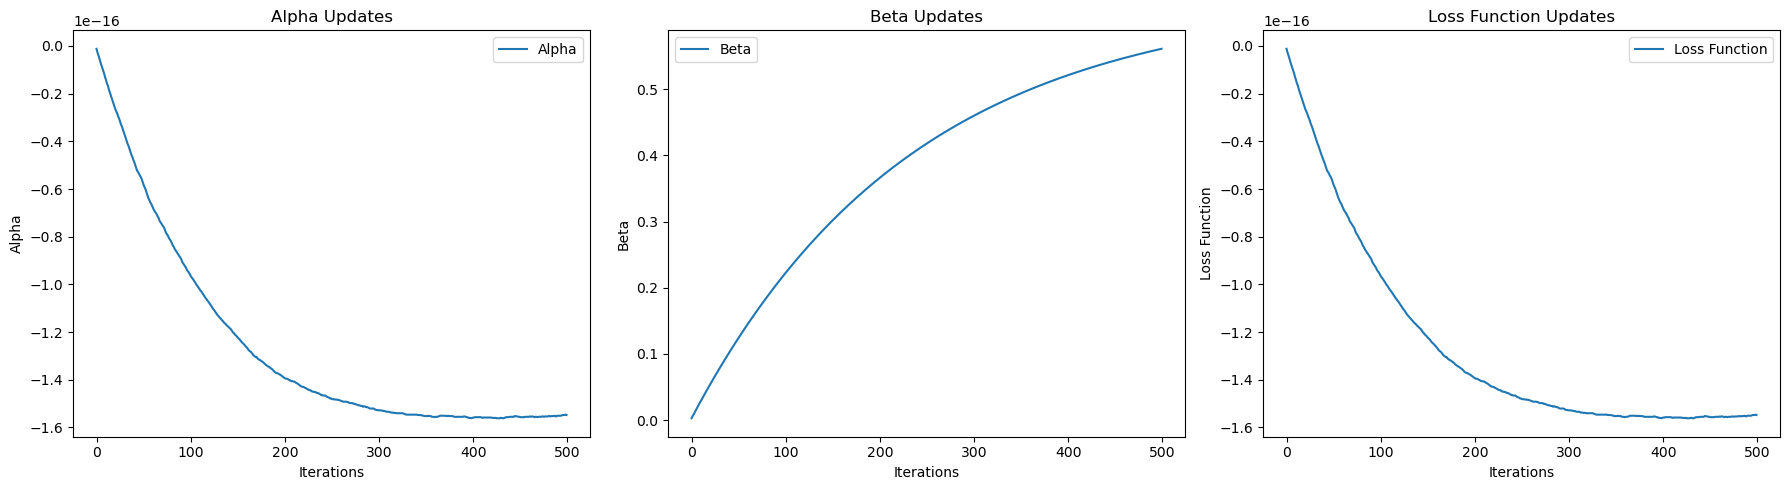

In [12]:
plt.figure(figsize=(18, 5))

#Alpha plot
plt.subplot(1, 3, 1)  
plt.plot(gd_alpha_history, label = "Alpha")
plt.title("Alpha Updates")
plt.xlabel("Iterations")
plt.ylabel("Alpha")
plt.legend()

#Beta plot
plt.subplot(1, 3, 2)  
plt.plot(gd_beta_history, label = "Beta")
plt.title("Beta Updates")
plt.xlabel("Iterations")
plt.ylabel("Beta")
plt.legend()

#Loss function plot
plt.subplot(1, 3, 3)
plt.plot(gd_alpha_history, label = "Loss Function")
plt.title("Loss Function Updates")
plt.xlabel("Iterations")
plt.ylabel("Loss Function")
plt.legend()

plt.tight_layout()
plt.show()

These three graphs illustrate the changes in the values for $\alpha$, $\beta$ and loss function over iterations using the gradient descent method. By observation, all variables converge to constant after 500 iterations. This means that our initial values and parameters are safe to use.

The initial normalised alpha and beta are set to 0 as a common practise before the optimisation process. By trial and error, the learning rate is set to 0.00425. (More decimal places are always more accurate, in here we just keep it as 5 decimal places of accuracy). 

Since our $\alpha$, $\beta$ and loss function are normalised, the next step is to denormalise these variables.

This can be performed by the denormalisation formula of:

$$
\beta = \hat{\beta} \times \frac {\sigma_{y}} {\sigma_{x}}
$$

- $\hat{\beta}$ is the normalised $x_{t}$
- $\sigma_{y}$ is the standard deviation of $y_{t}$
- $\sigma_{x}$ is the standard deviation of $x_{t}$

$$
\alpha = \overline{y_{t}} - \beta \times \overline{x_{t}}
$$

- $\overline{y_{t}}$ is the mean of $y_{t}$
- $\overline{x_{t}}$ is the meann of $x_{t}$

In [13]:
#Denormalise alpha and beta.
#Find the predicted value of y_t.
#Find the loss function.
gd_beta = norm_gd_beta * (np.std(y_t) / np.std(x_t))
gd_alpha = np.mean(y_t) - gd_beta * np.mean(x_t)
gd_y_hat = gd_alpha + np.multiply(gd_beta, x_t) 
gd_L = np.sum(np.multiply(y_t - gd_y_hat, y_t - gd_y_hat))

### Estimates of $\alpha$, $\beta$ and loss function from 2 methods.

In [14]:
print("Estimates from standard OLS formulae:",
      "\nAlpha =", ols_alpha.round(2), 
      "\nBeta =", ols_beta.round(2), 
      "\nLoss function =", ols_L.round(2))

Estimates from standard OLS formulae: 
Alpha = -10357.48 
Beta = 92.02 
Loss function = 2463424982.36


In [15]:
print("Estimates from gradient descent algorithm:",
      "\nAlpha =", gd_alpha.round(2), 
      "\nBeta =", gd_beta.round(2), 
      "\nLoss function =", gd_L.round(2))

Estimates from gradient descent algorithm: 
Alpha = -8222.6 
Beta = 81.08 
Loss function = 2487187946.26


The loss function for OLS regression is 2.46*10^8, while it is 2.49*10^8 using the gradient descent algorithm. This might suggest that the standard formula might be slightly more accurate than the machine learning approach. Therefore, the standard OLS formulae stands out as a better option for our time series analysis.

### The convergence challenge

When conducting the real-world finanical analysis, it is very common to encounter the overflow issue, this is when the gradient descent model fails to converge to optimise the parameters. Despite the relationship between the prices of BTC and Nvidia, driven by the correlation between the power of GPU (Graphics Processing Units) and blockchain mining speed, the market's complexity and volatility introduce noise into our OLS regression model. Besides, the increased maturity and substantial growth in cryptocurrency and Nvidia development in recent years has made our model more susceptible to outliers influenced by external factors.

Normalisation is a solution to address the convergence challenge. By normalising the input features, such as lists of $x_t$ and $y_t$ values, the method of gradient descent converges more rapidly, maintaining the numerical stability against overflow or underflow during the optimisation process.